# Emitter Receiver autoencoder model

In [1]:
import warnings; warnings.simplefilter('ignore')

import torch
import os
import time
import itertools
import collections
import torch.nn as nn
from cell import graph_utils, utils
from IPython.display import Image
from numpy.random import multinomial
from torch.nn import functional as F
from cell.Word2vec import prepare_vocab, dataloader, wv

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import imp
from cell import  utils, analysis, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(analysis)

imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [3]:
def preprocess_data(E_path, R_path, embedding_size):
    E = pd.read_csv(E_path, index_col="Unnamed: 0")
    R = pd.read_csv(R_path, index_col="Unnamed: 0")

    E, R = analysis.summarize_walk_embedding_results(
        {"E": E, "R":R}, 
        index=E.index.tolist(),
        embedding_size=embedding_size, 
        cl_df=utils.read_visp_npp_cldf(), 
        desired_cols=["cluster_color", "cluster_label"])
    
    return E, R

In [224]:
def plot_ndcg(adj, e_to_r, figsize, k):
    
    fig = plt.figure(figsize=figsize)

    nandcg = {}
    for n in e_to_r.index.tolist():
        nandcg[n] = analysis.get_distance_ndcg_score(n, e_to_r, adj, k=k)
            
    ax = fig.add_subplot(111)
    ax.scatter([ i for i in range(len(nandcg.keys()))], nandcg.values())
    ax.plot([v for v in nandcg.values()])
    ax.set_xticks([ i for i in range(len(nandcg.keys()))])
    ax.set_xticklabels(nandcg.keys(), rotation = 90)
    ax.set_xlabel("node_id")
    ylab = "ndcg@" + str(k)
    ax.set_ylabel(ylab)
    plt.show()
    return np.mean([v for v in nandcg.values()])

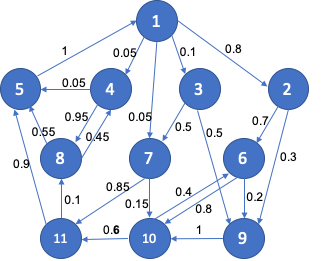

In [5]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=250, height=50)

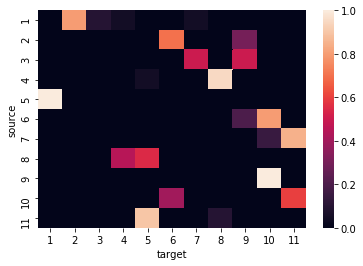

In [6]:
edges = pd.DataFrame([['1', '2', 0.8],
                      ['1', '3', 0.1],
                      ['1', '4', 0.05],
                      ['1', '7', 0.05],
                      ['2', '6', 0.7], 
                      ['2', '9', 0.3],
                      ['3', '9', 0.5],
                      ['3', '7', 0.5], 
                      ['4', '8', 0.95], 
                      ['4', '5', 0.05],
                      ['5', '1', 1], 
                      ['6', '9', 0.2], 
                      ['6', '10', 0.8],
                      ['7', '10', 0.15], 
                      ['7', '11', 0.85],
                      ['8', '5', 0.55],
                      ['8', '4', 0.45],
                      ['9', '10', 1], 
                      ['10', '11', 0.6], 
                      ['10', '6', 0.4],
                      ['11', '8', 0.1],
                      ['11', '5', 0.9]], columns=['source', 'target', 'weight'])

weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=True)
weight_mat = weight_mat.loc[[str(i) for i in range(1,12)]][[str(i) for i in range(1,12)]]
sns.heatmap(weight_mat)

We performed, weighted directed walks from each node of the graph. From each node, 100 walks was initiated and the length of each walk was 100 steps. This walks were used to create a inputs to each arm of the following model:

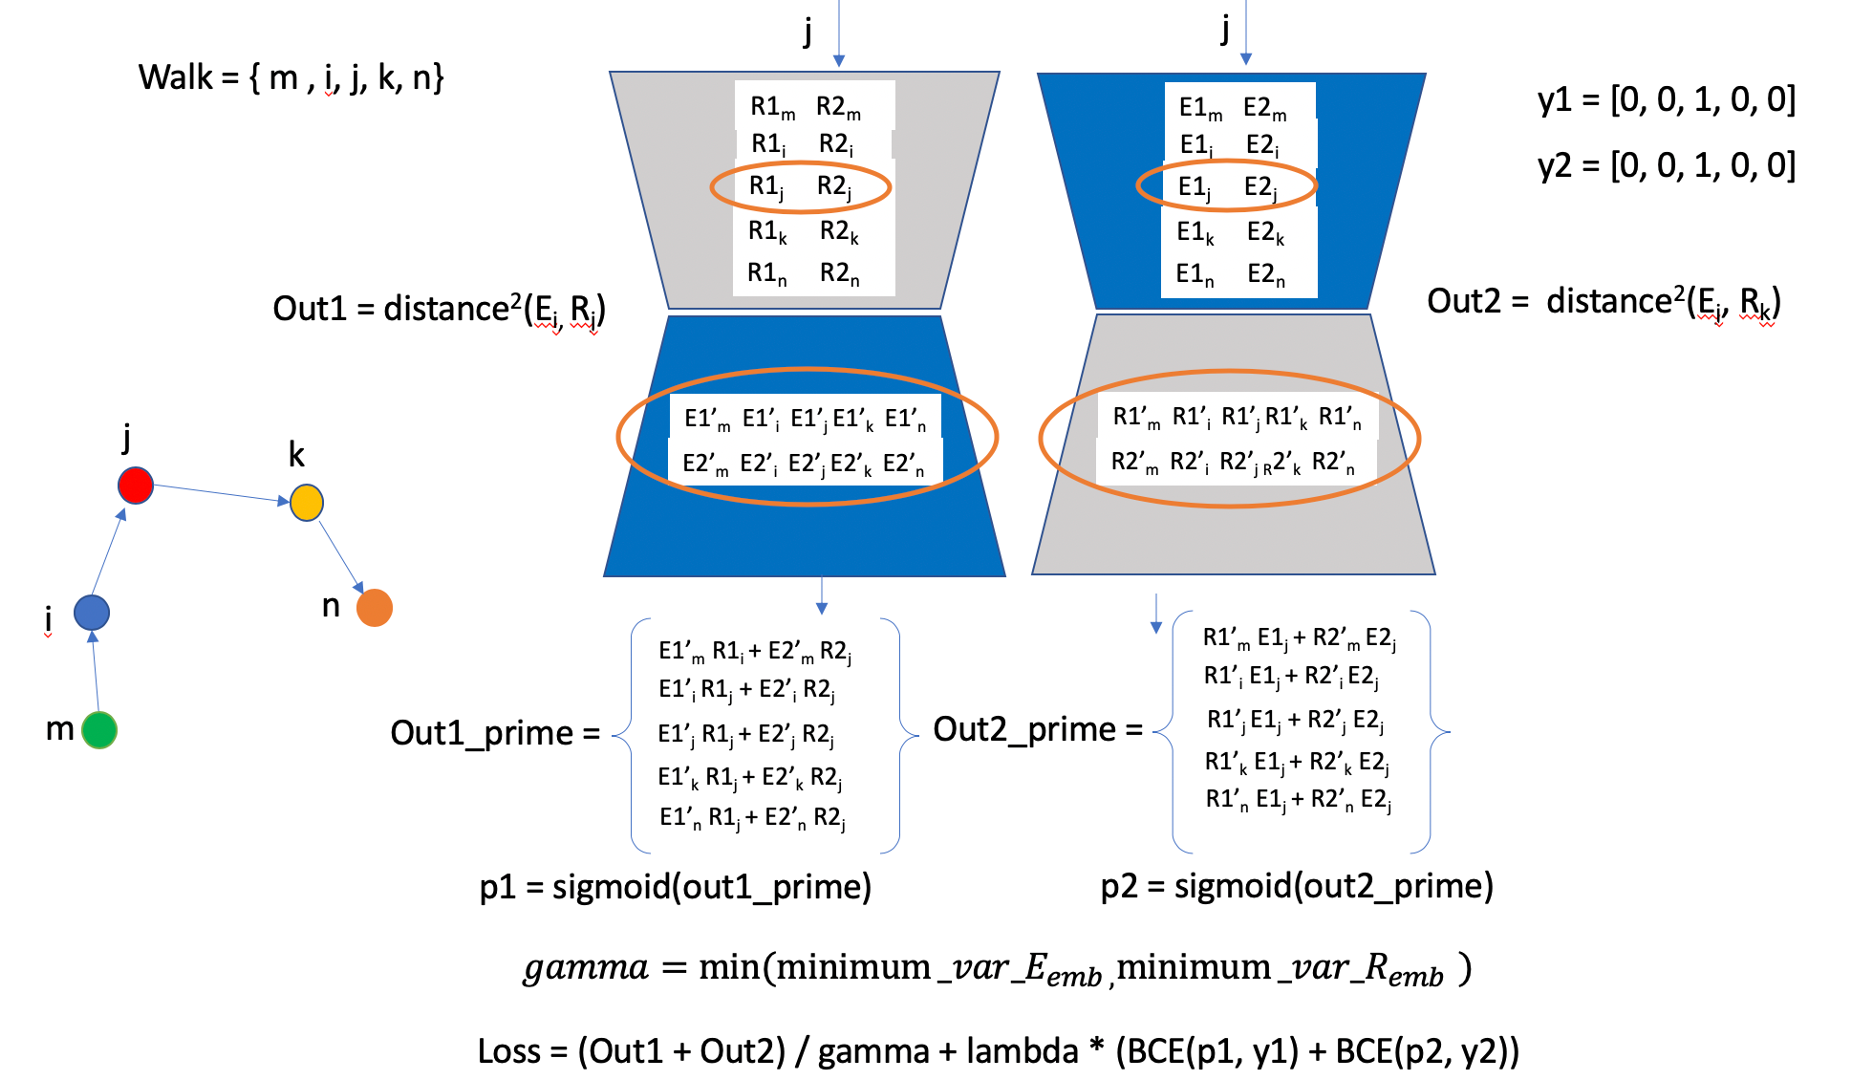

In [7]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/figures/E_R_encoder_decoder.png", width=1000, height=150)

Below, we show one embedding example that was obtained by the following parameters: lambda =1, embedding_size=2, w=1:

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


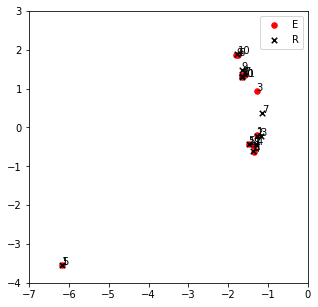

In [248]:
prep_E, prep_R = preprocess_data(E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/AE_BCE_lambda1_E_w1_2d.csv", 
                R_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/AE_BCE_lambda1_R_w1_2d.csv", embedding_size=2)

plot_utils.plot_ER(E=prep_E, 
                   R=prep_R, 
                   figsize=(5,5), 
                   plot_dim=2, 
                   annotation=True, 
                   E_color="Red", 
                   R_color="Black", 
                   E_marker='o', 
                   R_marker='x', 
                   use_type_colors=False, 
                   xlim=(-7, 0), 
                   ylim=(-4,3))

#### normalized discounted cumulative gain


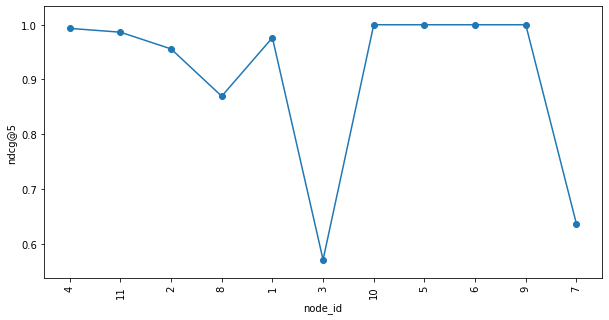

0.90800285470443

In [249]:
E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(prep_E[["Z0", "Z1"]], 
                                                                                        prep_R[["Z0", "Z1"]])
plot_ndcg(adj=weight_mat, e_to_r=E_to_R_dist, k=5, figsize=(10,5))

The above plot shows that the model is doing a good job in predicting the first 5 high rank edges for almost all the nodes except for node 3 and 7. If you look at the original graph, node 3 and 7 have a very small incoming weights and it is possible that those node were not well connected to the rest of the graph.

# NPP

First we read all the npp communication networks.

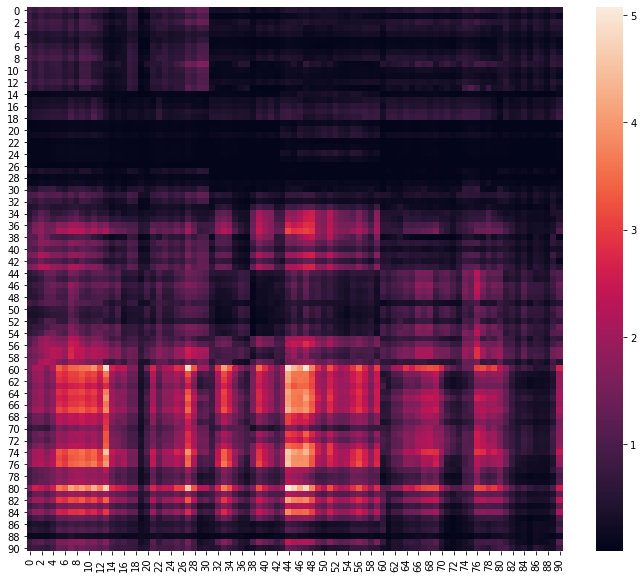

In [58]:
layers = utils.get_npp_visp_layers()
total_inter = np.zeros((93,93))

for layer in layers:
    path = utils.get_npp_visp_interaction_mat_path(layer)
    tmp_inter= pd.read_csv(path, index_col="Unnamed: 0")
    total_inter = total_inter + tmp_inter.values
    
adj = total_inter.astype(float)

adj = np.delete(adj, [21, 32], axis=0)
adj = np.delete(adj, [21, 32], axis=1)
fig = plt.figure(figsize=(12,10))
sns.heatmap(adj)

In [59]:
adj = pd.DataFrame(adj, 
                   index=[str(i) for i in range(93) if i not in [21, 32]], 
                   columns=[str(i) for i in range(93) if i not in [21, 32]])

#### Embedding with w =1, embedding_size=2, lambda=1

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


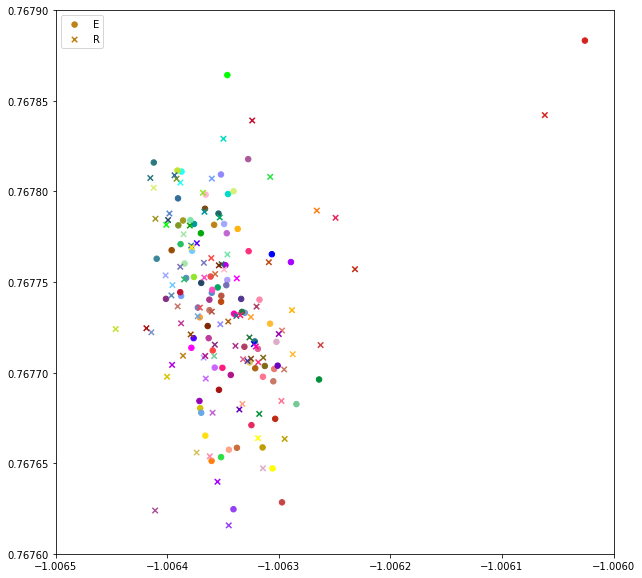

In [293]:
prep_E, prep_R = preprocess_data(
    E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda1_E_w1_bs2000_2d.csv",
    R_path="/Users/fahimehb//Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda1_R_w1_bs2000_2d.csv",
    embedding_size=2)

plot_utils.plot_ER(E=prep_E, 
                   R=prep_R, 
                   figsize=(10,10), 
                   plot_dim=2, 
                   annotation=False, 
                   E_color="Red", 
                   R_color="Black", 
                   E_marker='o', 
                   R_marker='x', 
                   use_type_colors=True, 
                   xlim=(-1.0065, -1.0060), 
                   ylim=(0.7676, 0.76790))

E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(prep_E[["Z0", "Z1"]], 
                                                                                        prep_R[["Z0", "Z1"]])

E_to_R_dist = E_to_R_dist.loc[[str(i) for i in range(93) if i not in [21, 32]]]\
[[str(i) for i in range(93) if i not in [21, 32]]]

#### How well the model is prediciting the first 5 high rank edges for each node

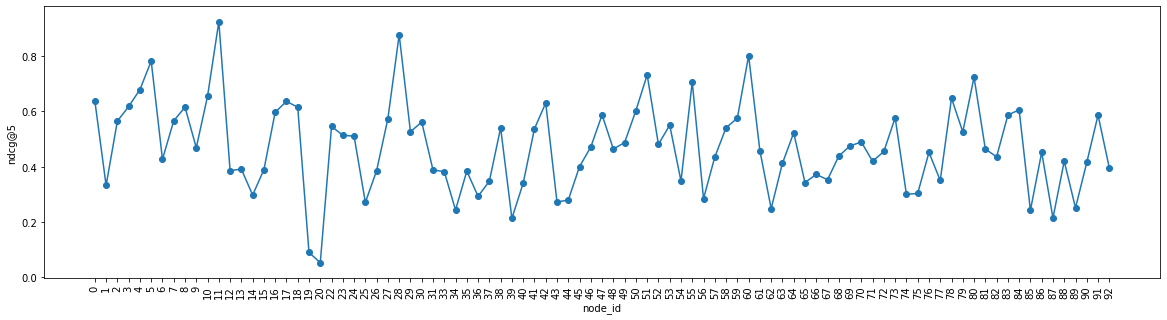

0.4697396448214751

In [294]:
plot_ndcg(adj=adj, e_to_r=E_to_R_dist, k=5, figsize=(20,5))

For a reference point let's look at node 11 which has a high value of around 0.85, the first five nodes that are receiving signal from node '11' are:

In [233]:
print(E_to_R_dist.columns[[np.argsort(E_to_R_dist.loc['11'])]][0:5])

Index(['30', '10', '5', '0', '28'], dtype='object')


And the 5 highest weight values going out of node '11' are going to the following nodes:

In [234]:
print(adj.columns[[np.argsort(-adj.loc['11'])]][0:5])

Index(['30', '31', '28', '9', '0'], dtype='object')


As it is clear, our model has predicted at least node 30, node 28 and node 0 among the high rank nodes for this specific node. So the model is almost doing a good job if the ndcg scores are more than 0.7 more or less. For example for node 31 which has a value of around 0.5 ndcg@5. lets see what are the predictions:


In [243]:
print(E_to_R_dist.columns[[np.argsort(E_to_R_dist.loc['31'])]][0:5])

Index(['57', '46', '67', '83', '8'], dtype='object')


In [242]:
print(adj.columns[[np.argsort(-adj.loc['31'])]][0:5])

Index(['4', '3', '30', '9', '2'], dtype='object')


None of the first 5 nodes are predicted correctly.

#### Embedding with w =1, embedding_size=2, lambda=0.1

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


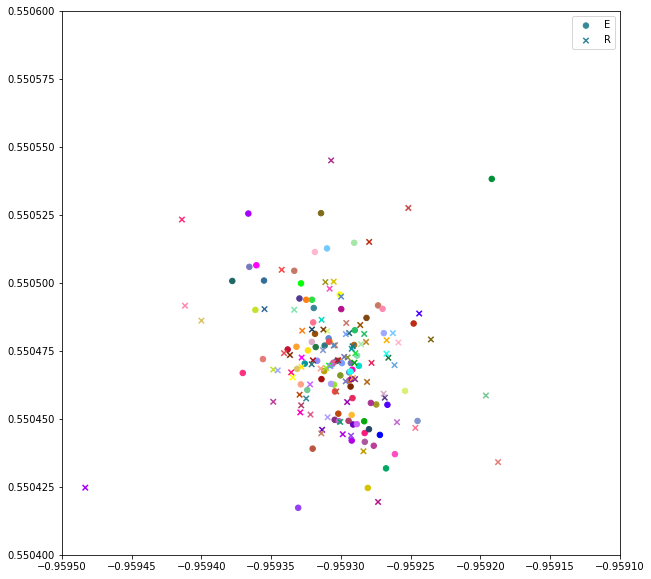

In [291]:
prep_E, prep_R = preprocess_data(
    E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda0.1_E_w1_bs2000_2d.csv", 
    R_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda0.1_R_w1_bs2000_2d.csv", 
    embedding_size=2)

plot_utils.plot_ER(E=prep_E, 
                   R=prep_R, 
                   figsize=(10,10), 
                   plot_dim=2, 
                   annotation=False, 
                   E_color="Red", 
                   R_color="Black", 
                   E_marker='o', 
                   R_marker='x', 
                   use_type_colors=True, 
                   xlim=(-.9595, -0.9591), 
                   ylim=(0.5504, 0.5506))

E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(prep_E[["Z0", "Z1"]], 
                                                                                        prep_R[["Z0", "Z1"]])

E_to_R_dist = E_to_R_dist.loc[[str(i) for i in range(93) if i not in [21, 32]]]\
[[str(i) for i in range(93) if i not in [21, 32]]]

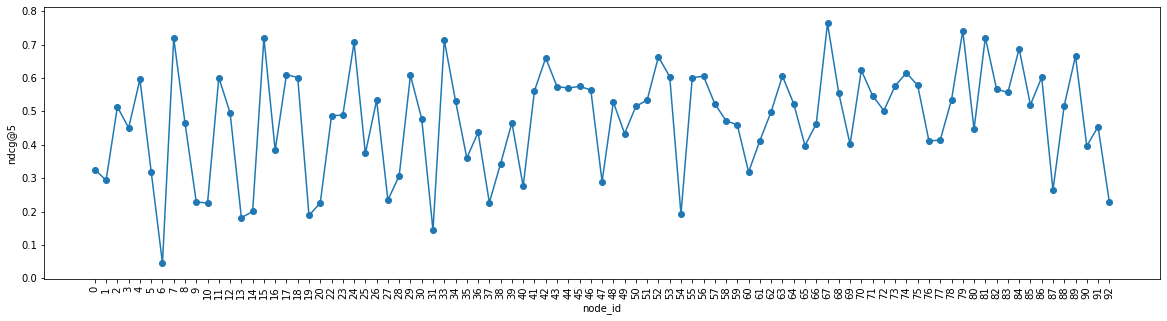

0.47402330577239055

In [292]:
plot_ndcg(adj=adj, e_to_r=E_to_R_dist, k=5, figsize=(20,5))

Again the average value for among all nodes is around 0.47 which is not good!

#### Embedding with w =1, embedding_size=2, lambda=10

In [289]:
prep_E, prep_R = preprocess_data(
    E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda10_E_w1_bs2000_2d.csv", 
    R_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda10_R_w1_bs2000_2d.csv", 
    embedding_size=2)

E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(prep_E[["Z0", "Z1"]], 
                                                                                        prep_R[["Z0", "Z1"]])

E_to_R_dist = E_to_R_dist.loc[[str(i) for i in range(93) if i not in [21, 32]]]\
[[str(i) for i in range(93) if i not in [21, 32]]]

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


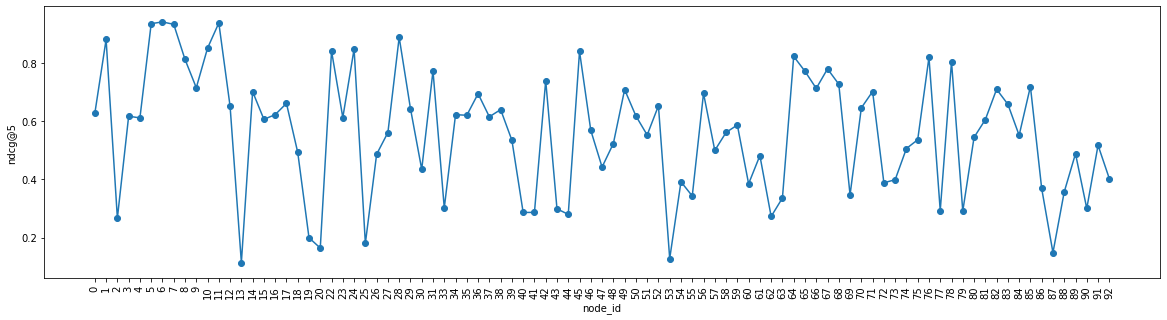

0.5604333382479547

In [290]:
plot_ndcg(adj=adj, e_to_r=E_to_R_dist, k=5, figsize=(20,5))

With larger lambda the results are maybe getting better!

#### Embedding size=5, lambda=1, w=1

In [286]:
prep_E, prep_R = preprocess_data(
    E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda1_E_w1_bs2000_5d.csv", 
    R_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/keep/AE_NPP_BCE_lambda1_R_w1_bs2000_5d.csv", 
    embedding_size=5
)

E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(
    prep_E[["Z0", "Z1", "Z2", "Z3", "Z4"]], 
    prep_R[["Z0", "Z1", "Z2", "Z3", "Z4"]]
)

E_to_R_dist = E_to_R_dist.loc[[str(i) for i in range(93) if i not in [21, 32]]]\
[[str(i) for i in range(93) if i not in [21, 32]]]


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


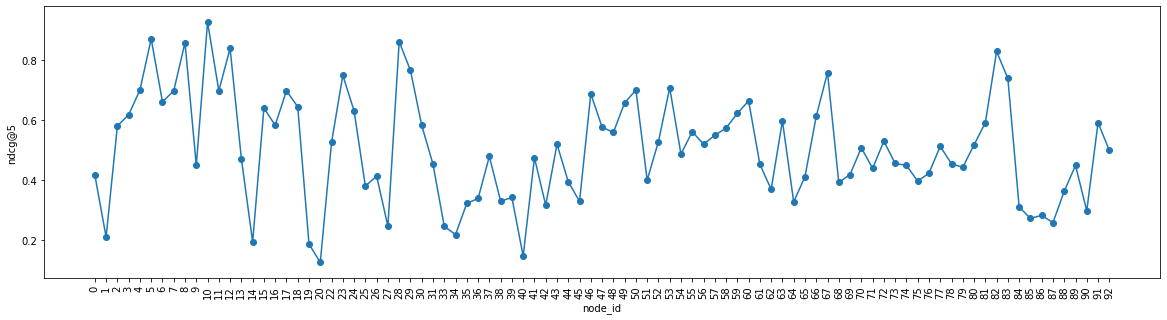

0.5041796091965485

In [287]:
plot_ndcg(adj=adj, e_to_r=E_to_R_dist, k=5, figsize=(20,5))

It is slightly better than embedding size=2

#### Embedding size=15, lambda=1, w=1

In [305]:
prep_E, prep_R = preprocess_data(
    E_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/AE_NPP_BCE_lambda1_E_w1_bs2000_15d.csv", 
    R_path="/Users/fahimehb/Documents/NPP_GNN_project/dat/AE_NPP_BCE_lambda1_R_w1_bs2000_15d.csv", 
    embedding_size=15
)

E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(
    prep_E[["Z" + str(i) for i in range(15)]], 
    prep_R[["Z" + str(i) for i in range(15)]]
)

#"Z2", "Z3", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9"

E_to_R_dist = E_to_R_dist.loc[[str(i) for i in range(93) if i not in [21, 32]]]\
[[str(i) for i in range(93) if i not in [21, 32]]]

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


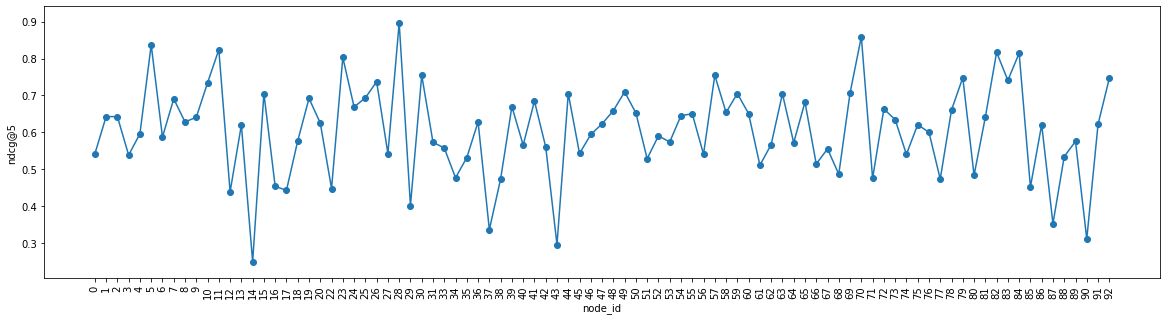

0.6051553177608235

In [285]:
plot_ndcg(adj=adj, e_to_r=E_to_R_dist, k=5, figsize=(20,5))

In [316]:
print(E_to_R_dist.columns[[np.argsort(E_to_R_dist.loc['5'])]][0:5])

Index(['30', '25', '6', '31', '0'], dtype='object')


In [317]:
print(adj.columns[[np.argsort(-adj.loc['5'])]][0:5])

Index(['30', '31', '28', '9', '10'], dtype='object')
